# Importing the Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor

 # Data Loading

In [4]:
# loading the data from csv file to a Pandas DataFrame
df = pd.read_csv('insurance.csv')

In [5]:
# first 5 rows of the dataframe
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
# number of rows and columns
print(df.shape)

(1338, 7)


In [7]:
pd.set_option("display.max_columns", None)

In [8]:
# getting some informations about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Categorical Features:
- Sex
- Smoker
- Region

# Data Cleaning

In [11]:
# checking for missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [12]:
# Duplicate Rows
duplicate_count = df.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

Duplicate rows: 1


In [13]:
df = df.drop_duplicates()

In [14]:
print(df.shape)

(1337, 7)


In [15]:
# printing the unique values of specific columns
excluded = ['bmi', 'age', 'charges']

for col in df.columns:
  if col not in excluded:
    print(col, df[col].unique())
    print("-"*50)

sex ['female' 'male']
--------------------------------------------------
children [0 1 3 2 5 4]
--------------------------------------------------
smoker ['yes' 'no']
--------------------------------------------------
region ['southwest' 'southeast' 'northwest' 'northeast']
--------------------------------------------------


# Exploratory Data Analysis

In [17]:
df.shape

(1337, 7)

In [18]:
# statistical Measures of the dataset
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


In [19]:
# Mode Values
mode_values = df.mode().iloc[0]
mode_values

age              18.0
sex              male
bmi              32.3
children          0.0
smoker             no
region      southeast
charges     1121.8739
Name: 0, dtype: object

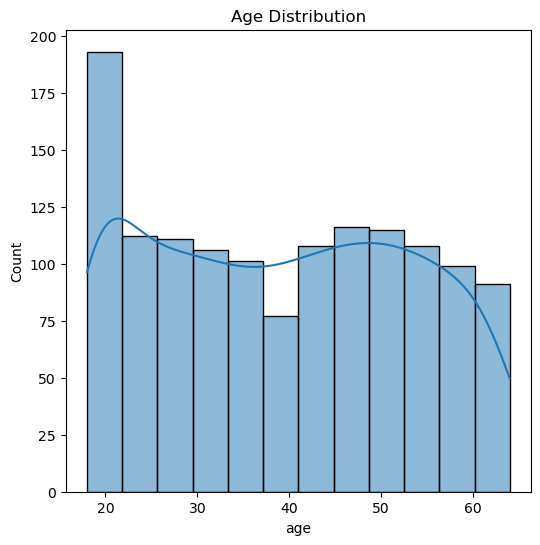

In [20]:
plt.figure(figsize=(6,6))
sns.histplot(x='age', data=df,kde=True)
plt.title('Age Distribution')
plt.show()

- The distribution appears to be fairly uniform, with no strong skewness.
- Most ages range from the early 20s to early 60s, indicating a wide coverage of adult individuals.

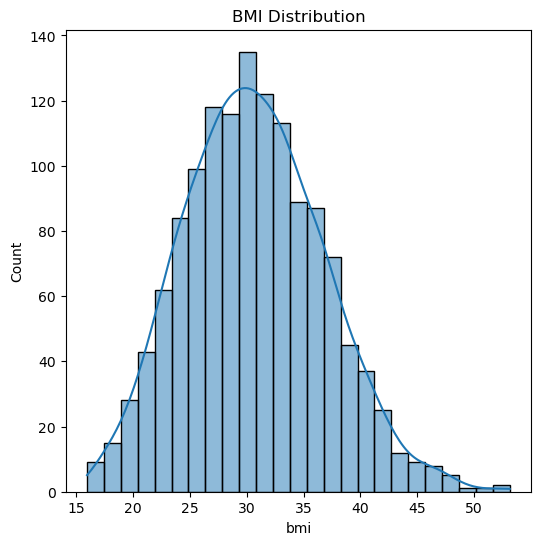

In [22]:
plt.figure(figsize=(6,6))
sns.histplot(df['bmi'],kde=True)
plt.title('BMI Distribution')
plt.show()

- A normal BMI (Body Mass Index) range for adults is 18.5 to 24.9 kg/m². 
This indicates a healthy weight range, while a BMI below 18.5 is considered **underweight** and a BMI of 25 or higher is considered **overweight** or obese. 
- The histogram of BMI shows that most individuals have a BMI between **25 and 35**.
- Since BMI is related to health risks, it is likely to be a strong predictor of medical charges.


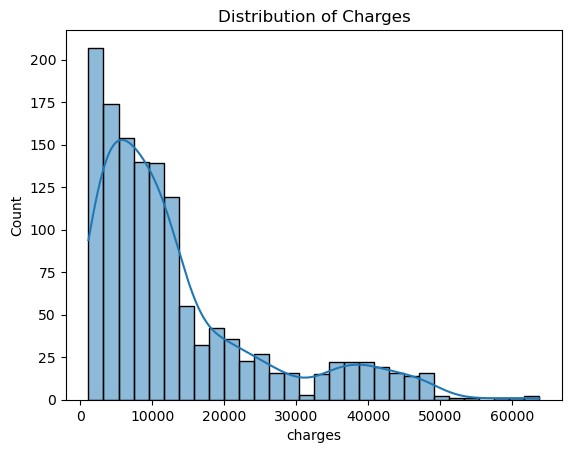

In [24]:
# Histogram for target column
sns.histplot(df['charges'], kde=True, bins=30)
plt.title("Distribution of Charges")
plt.show()

- The distribution of medical charges is **right-skewed**, with most charges concentrated at the lower end and a few extremely high values.
- These **high-cost outliers** may correspond to individuals with serious medical conditions or smokers.

In [26]:
df['charges'] = np.log1p(df['charges'])

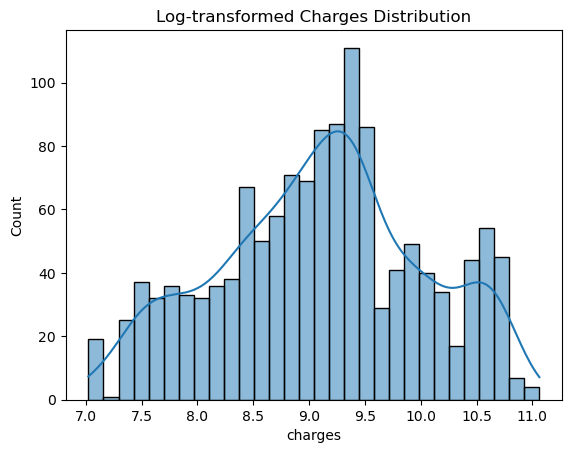

In [27]:
sns.histplot((df['charges']), bins=30, kde=True)
plt.title("Log-transformed Charges Distribution")
plt.show()

- To reduce skewness, a **log transformation** was applied.
- This transformation helps stabilize variance and improves model performance by making the target distribution more normal-like.

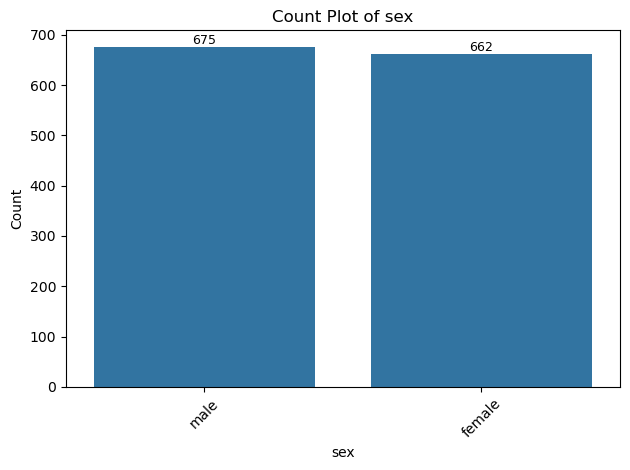

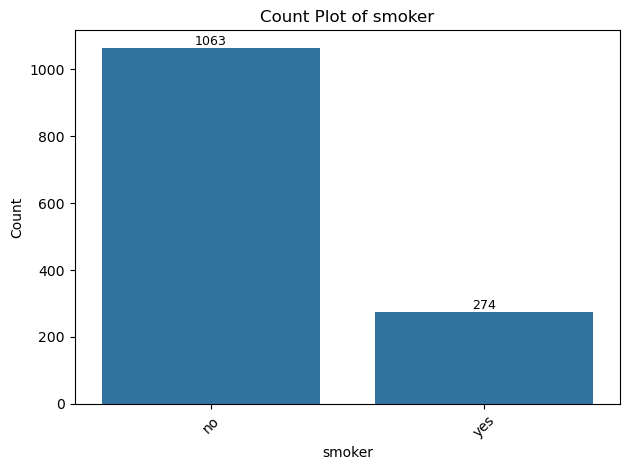

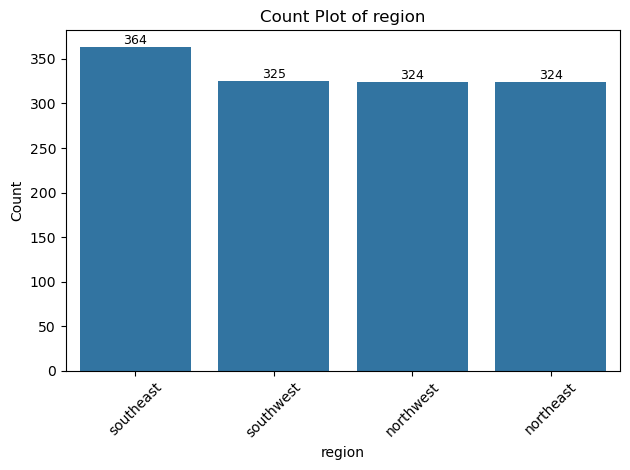

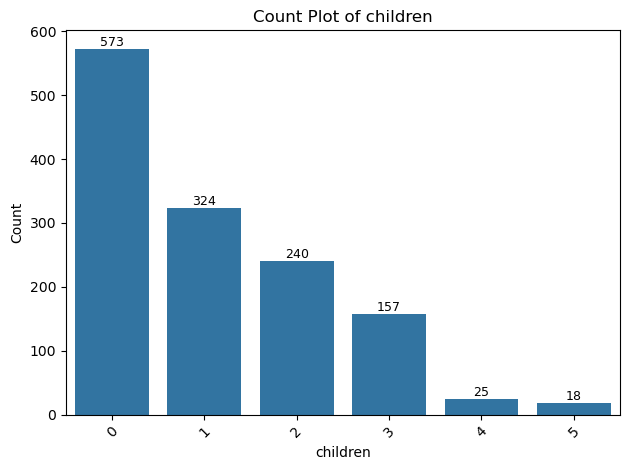

In [29]:
# Count plot for specific columns
cols = ['sex','smoker','region','children']
for col in cols:
    ax=sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Count Plot of {col}')
    plt.ylabel('Count')

    # Annotate values on bars
    for container in ax.containers:
        ax.bar_label(container, label_type='edge', fontsize=9)
    plt.tight_layout()
    plt.show()


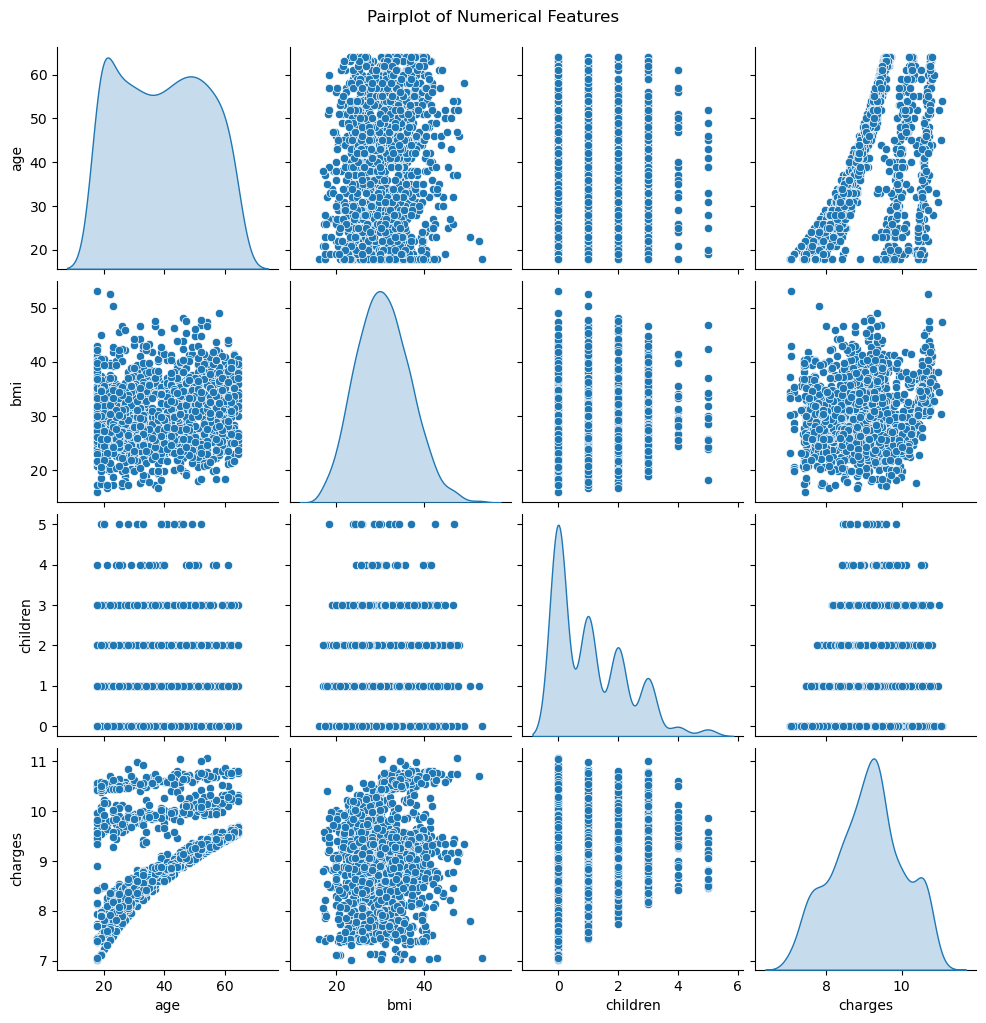

In [30]:
# Select relevant numeric columns
pairplot_data = df[['age', 'bmi', 'children', 'charges']]

sns.pairplot(pairplot_data, diag_kind='kde')
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

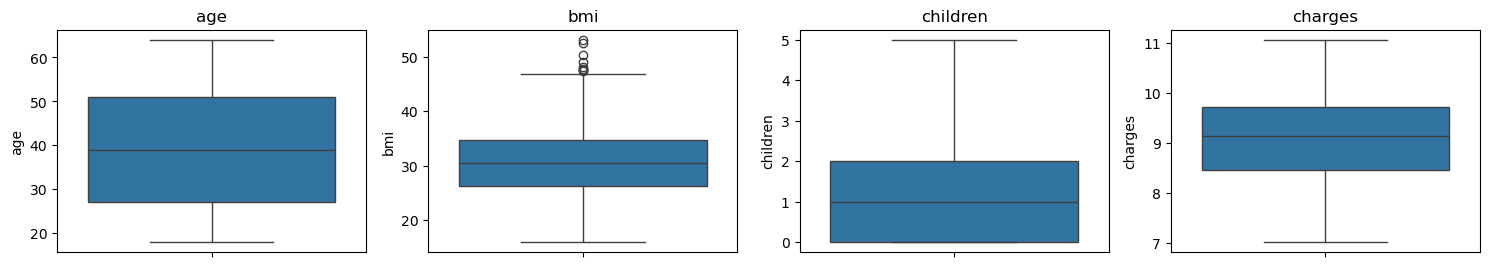

In [31]:
# Outlier Detection with Boxplots in Numerical_Columns
numerical_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

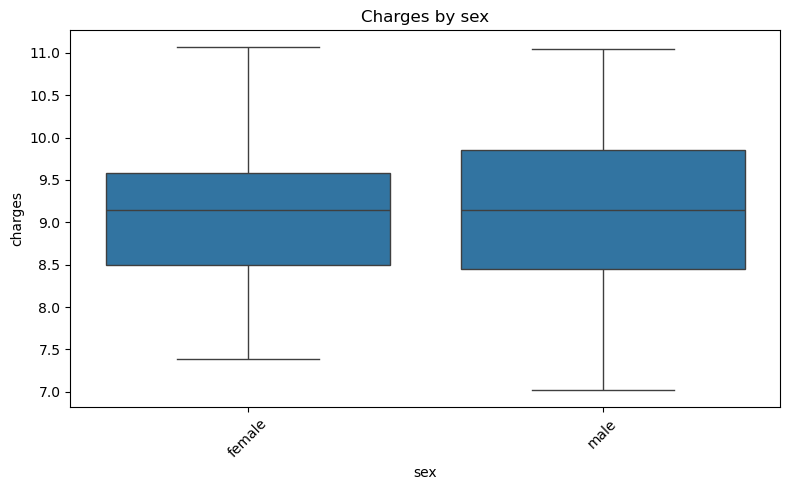

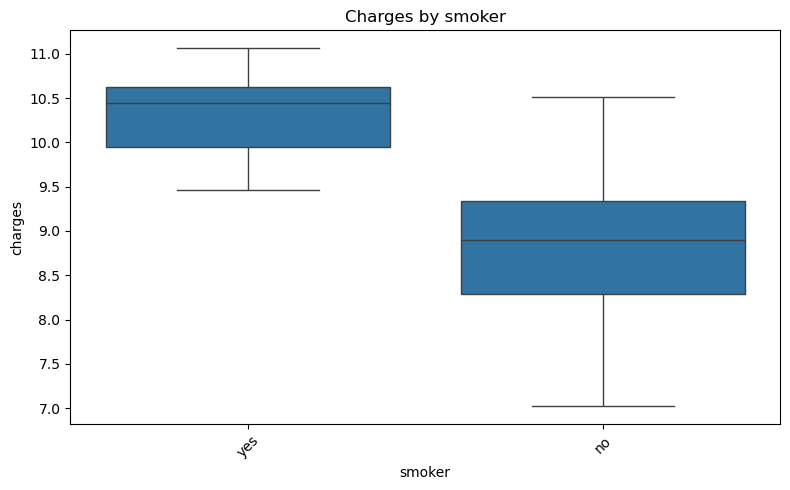

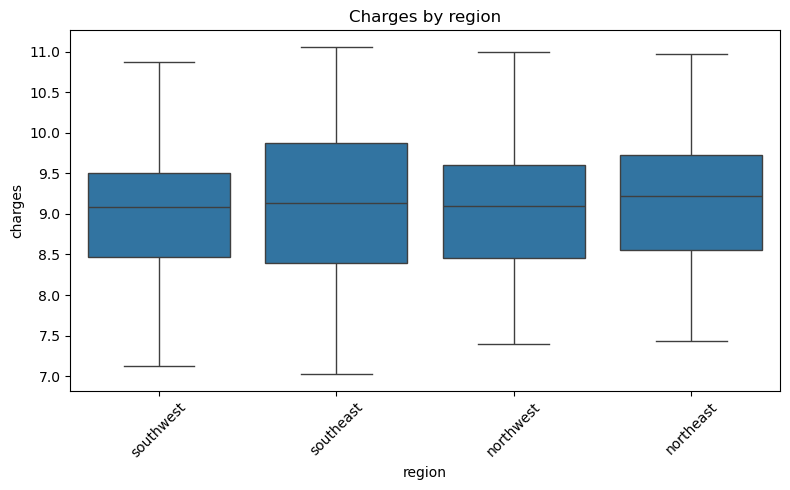

In [32]:
# Boxplots for Categorical features vs charges
col_s = ['sex','smoker', 'region']

for col in col_s:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=col, y='charges', data=df)
    plt.title(f'Charges by {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Insights :**

- There is a **clear and significant difference** in charges between smokers and non-smokers.
- Smokers tend to incur **much higher medical charges**.
- The boxplot of region vs charges shows **no major variation** across different geographic regions.
- The boxplot above compares medical charges between **male and female** individuals.
- The distribution of charges is **very similar** across both sexes. There is **no significant difference** in the median or spread of charges between males and females.

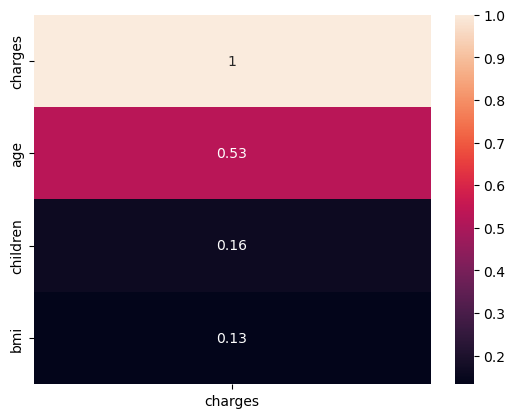

In [35]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr[['charges']].sort_values(by='charges', ascending=False), annot=True)
plt.show()

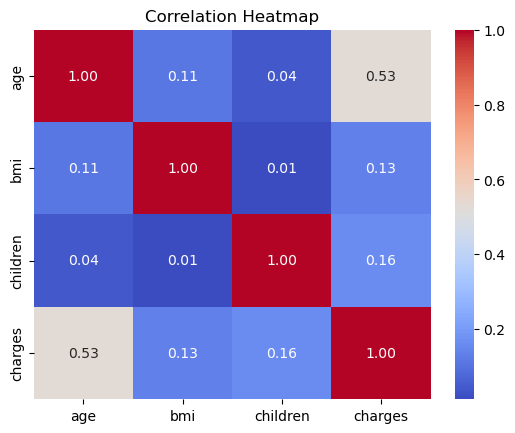

In [36]:
numerical_cols = ['age', 'bmi', 'children','charges']
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Data Pre-Processing

**Splitting the Features and Target**

In [39]:
X = df.drop(columns='charges', axis=1)
Y = df['charges']

In [40]:
print(X)

      age     sex     bmi  children smoker     region
0      19  female  27.900         0    yes  southwest
1      18    male  33.770         1     no  southeast
2      28    male  33.000         3     no  southeast
3      33    male  22.705         0     no  northwest
4      32    male  28.880         0     no  northwest
...   ...     ...     ...       ...    ...        ...
1333   50    male  30.970         3     no  northwest
1334   18  female  31.920         0     no  northeast
1335   18  female  36.850         0     no  southeast
1336   21  female  25.800         0     no  southwest
1337   61  female  29.070         0    yes  northwest

[1337 rows x 6 columns]


In [41]:
print(Y)

0        9.734236
1        7.453882
2        8.400763
3        9.998137
4        8.260455
          ...    
1333     9.268755
1334     7.699381
1335     7.396847
1336     7.605365
1337    10.279948
Name: charges, Length: 1337, dtype: float64


**Splitting the data into Training data & Testing Data**

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [44]:
print(X.shape, X_train.shape, X_test.shape)

(1337, 6) (1069, 6) (268, 6)


In [45]:
print(Y.shape, Y_train.shape, Y_test.shape)

(1337,) (1069,) (268,)


**Encoding the categorical features & Scaling numerical features**

In [47]:
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Model Training

In [49]:
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

# Evaluation Function

results = []

def evaluate_model(name, model):
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ]) if 'Pipeline' not in str(type(model)) else model

    pipe.fit(X_train, Y_train)

    Y_train_pred = pipe.predict(X_train)
    Y_test_pred = pipe.predict(X_test)

    Y_train_pred_inv = np.expm1(Y_train_pred)
    Y_test_pred_inv = np.expm1(Y_test_pred)
    Y_train_inv = np.expm1(Y_train)
    Y_test_inv = np.expm1(Y_test)

    train_r2 = r2_score(Y_train_inv, Y_train_pred_inv)
    test_r2 = r2_score(Y_test_inv, Y_test_pred_inv)
    k = preprocessor.fit(X_train).transform(X_train).shape[1]
    adj_r2 = adjusted_r2(test_r2, X_test.shape[0], k)

    rmse = mean_squared_error(Y_test_inv, Y_test_pred_inv, squared=False)
    mae = mean_absolute_error(Y_test_inv, Y_test_pred_inv)
    mse = mean_squared_error(Y_test_inv, Y_test_pred_inv)

    results.append({
        'Model': name,
        'Train R2': train_r2,
        'Test R2': test_r2,
        'Adjusted R2': adj_r2,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    })

    print(f"\n {name} Evaluation:")
    print(f"Train R² Score: {train_r2:.4f}")
    print(f"Test R² Score:  {test_r2:.4f}")
    print(f"Adjusted R²:    {adj_r2:.4f}")
    print(f"MAE:            {mae:.2f}")
    print(f"MSE:            {mse:.2f}")
    print(f"RMSE:           {rmse:.2f}")

In [50]:

poly_features = PolynomialFeatures(degree=2, include_bias=False)
poly_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', poly_features),
    ('regressor', LinearRegression())
])

models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression': poly_pipe,
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0),
}

## Model Evaluation

In [52]:
print("\n Base Model Comparisons:")
for name, model in models.items():
    evaluate_model(name, model)


 Base Model Comparisons:

 Linear Regression Evaluation:
Train R² Score: 0.4860
Test R² Score:  0.7181
Adjusted R²:    0.7094
MAE:            3755.92
MSE:            51797278.35
RMSE:           7197.03

 Polynomial Regression Evaluation:
Train R² Score: 0.8093
Test R² Score:  0.8671
Adjusted R²:    0.8630
MAE:            2576.81
MSE:            24427931.52
RMSE:           4942.46

 Decision Tree Evaluation:
Train R² Score: 1.0000
Test R² Score:  0.7758
Adjusted R²:    0.7689
MAE:            3017.70
MSE:            41202475.72
RMSE:           6418.92

 Random Forest Evaluation:
Train R² Score: 0.9584
Test R² Score:  0.8944
Adjusted R²:    0.8911
MAE:            2103.80
MSE:            19404566.58
RMSE:           4405.06

 HistGradientBoosting Evaluation:
Train R² Score: 0.9148
Test R² Score:  0.8945
Adjusted R²:    0.8912
MAE:            2273.51
MSE:            19392609.51
RMSE:           4403.70

 XGBoost Evaluation:
Train R² Score: 0.9928
Test R² Score:  0.8587
Adjusted R²:    0.8543

In [53]:
# Metrics DataFrame
results_df = pd.DataFrame(results).sort_values(by='RMSE').reset_index(drop=True)
print("\n Model Performance Summary:")
print(results_df)


 Model Performance Summary:
                   Model  Train R2   Test R2  Adjusted R2          MAE  \
0   HistGradientBoosting  0.914825  0.894465     0.891206  2273.507698   
1          Random Forest  0.958439  0.894400     0.891139  2103.795312   
2  Polynomial Regression  0.809327  0.867063     0.862957  2576.813637   
3                XGBoost  0.992754  0.858663     0.854297  2663.224228   
4          Decision Tree  1.000000  0.775776     0.768850  3017.700194   
5      Linear Regression  0.485962  0.718119     0.709413  3755.924576   

            MSE         RMSE  
0  1.939261e+07  4403.704067  
1  1.940457e+07  4405.061473  
2  2.442793e+07  4942.462091  
3  2.597156e+07  5096.230215  
4  4.120248e+07  6418.915463  
5  5.179728e+07  7197.032607  


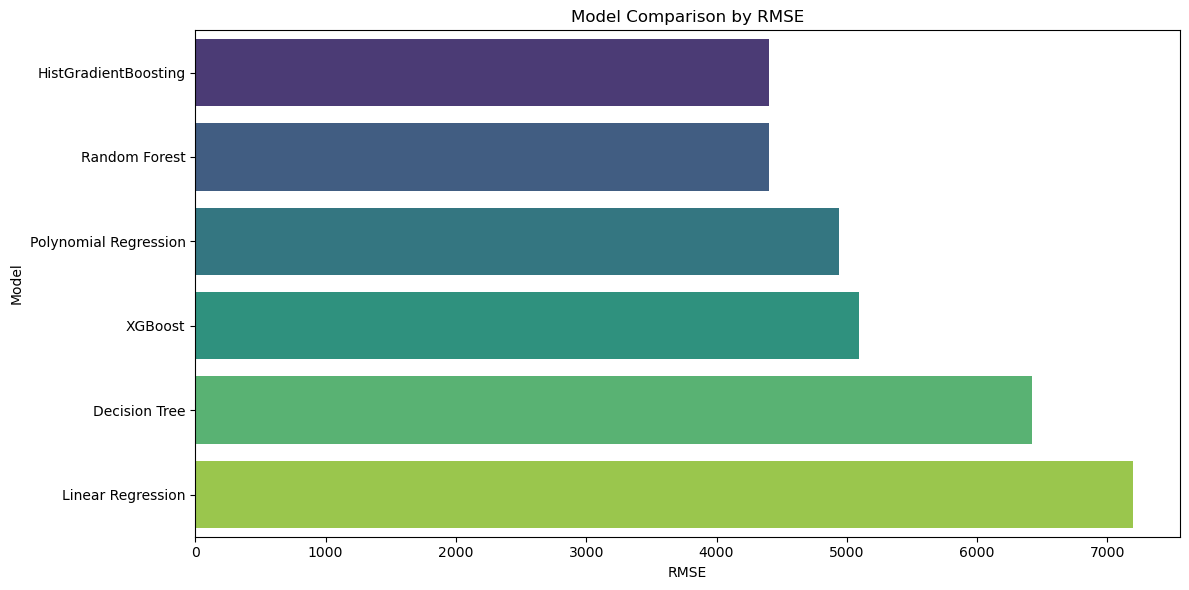

In [54]:
# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis')
plt.title('Model Comparison by RMSE')
plt.xlabel('RMSE')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

# Hyperparameter Tuning

In [56]:
#  Hyperparameter Tuning: HistGradientBoosting

import time
# Start time
start = time.time()

hist_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor',HistGradientBoostingRegressor(random_state=42))
])

param_grid = {
    'regressor__learning_rate': [0.05, 0.1],              
    'regressor__max_iter': [100, 200],                    
    'regressor__max_depth': [3, None],                    
    'regressor__l2_regularization': [0.0, 0.1],           
    'regressor__min_samples_leaf': [20, 30]               
}

grid_search = GridSearchCV(hist_pipe, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, Y_train)

# End time
training_time = time.time() - start

#Evaluate best model from GridSearch
best_model = grid_search.best_estimator_

# Predictions
Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)

# Inverse log1p
Y_train_pred_inv = np.expm1(Y_train_pred)
Y_test_pred_inv = np.expm1(Y_test_pred)
Y_train_inv = np.expm1(Y_train)
Y_test_inv = np.expm1(Y_test)

# Metrics
train_r2 = r2_score(Y_train_inv, Y_train_pred_inv)
test_r2 = r2_score(Y_test_inv, Y_test_pred_inv)
k = preprocessor.fit(X_train).transform(X_train).shape[1]
adj_r2 = adjusted_r2(test_r2, X_test.shape[0], k)

mae = mean_absolute_error(Y_test_inv, Y_test_pred_inv)
mse = mean_squared_error(Y_test_inv, Y_test_pred_inv)
rmse = mean_squared_error(Y_test_inv, Y_test_pred_inv, squared=False)

# Output
print("\n HistGradientBoostingRegressor Best Model Params:")
print(grid_search.best_params_)
print(f"Train R² Score:    {train_r2:.4f}")
print(f"Test R² Score:     {test_r2:.4f}")
print(f"Adjusted R²:       {adj_r2:.4f}")
print(f"MAE:               {mae:.2f}")
print(f"MSE:               {mse:.2f}")
print(f"RMSE:              {rmse:.2f}")
print(f"Training Time:     {training_time:.2f} seconds")



 HistGradientBoostingRegressor Best Model Params:
{'regressor__l2_regularization': 0.1, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__max_iter': 100, 'regressor__min_samples_leaf': 20}
Train R² Score:    0.8583
Test R² Score:     0.8967
Adjusted R²:       0.8935
MAE:               2038.28
MSE:               18978792.46
RMSE:              4356.47
Training Time:     33.19 seconds


In [57]:
#  Hyperparameter Tuning: Random Forest
import time
# Start time
start = time.time()

rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

rf_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(rf_pipe, rf_params, cv=5, scoring='neg_root_mean_squared_error',verbose=1)
grid_rf.fit(X_train, Y_train)

# End time
training_time = time.time() - start

#Evaluate best model from GridSearch
best_model = grid_rf.best_estimator_

# Predictions
Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)

# Inverse log1p
Y_train_pred_inv = np.expm1(Y_train_pred)
Y_test_pred_inv = np.expm1(Y_test_pred)
Y_train_inv = np.expm1(Y_train)
Y_test_inv = np.expm1(Y_test)

# Metrics
train_r2 = r2_score(Y_train_inv, Y_train_pred_inv)
test_r2 = r2_score(Y_test_inv, Y_test_pred_inv)
k = preprocessor.fit(X_train).transform(X_train).shape[1]
adj_r2 = adjusted_r2(test_r2, X_test.shape[0], k)

mae = mean_absolute_error(Y_test_inv, Y_test_pred_inv)
mse = mean_squared_error(Y_test_inv, Y_test_pred_inv)
rmse = mean_squared_error(Y_test_inv, Y_test_pred_inv, squared=False)

# Output
print("\n RandomForestRegressor Best Model Params:")
print(grid_rf.best_params_)
print(f"Train R² Score:    {train_r2:.4f}")
print(f"Test R² Score:     {test_r2:.4f}")
print(f"Adjusted R²:       {adj_r2:.4f}")
print(f"MAE:               {mae:.2f}")
print(f"MSE:               {mse:.2f}")
print(f"RMSE:              {rmse:.2f}")
print(f"Training Time:     {training_time:.2f} seconds")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

 RandomForestRegressor Best Model Params:
{'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
Train R² Score:    0.9236
Test R² Score:     0.8984
Adjusted R²:       0.8952
MAE:               2060.76
MSE:               18676606.77
RMSE:              4321.64
Training Time:     15.63 seconds


**Since R^2 values are close to 1, our model is a good fit**
- After the last step, we can comment that Our Model can give 89.84% accurate results which is pretty good.

# Prediction Using Hypertuned Random Forest Model

In [60]:
# Create DataFrame of Actual vs Predicted
results_df = pd.DataFrame({
    'Actual Total Charge': Y_test_inv,
    'Predicted Total Charge': Y_test_pred_inv
})
results_df.reset_index(drop=True, inplace=True)

print(results_df.head())

   Actual Total Charge  Predicted Total Charge
0           8688.85885             9190.157904
1           5708.86700             7104.889681
2          11436.73815            11632.523994
3          38746.35510            41852.676218
4           4463.20510             5318.536817


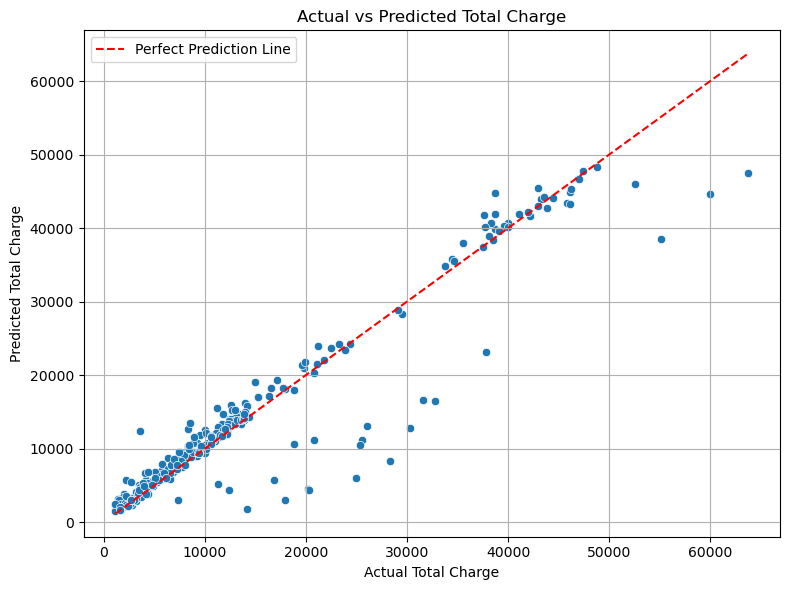

In [61]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual Total Charge', y='Predicted Total Charge', data=results_df)
plt.plot([results_df.min().min(), results_df.max().max()],
         [results_df.min().min(), results_df.max().max()],
         color='red', linestyle='--', label='Perfect Prediction Line')
plt.title('Actual vs Predicted Total Charge')
plt.xlabel('Actual Total Charge')
plt.ylabel('Predicted Total Charge')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature Importance

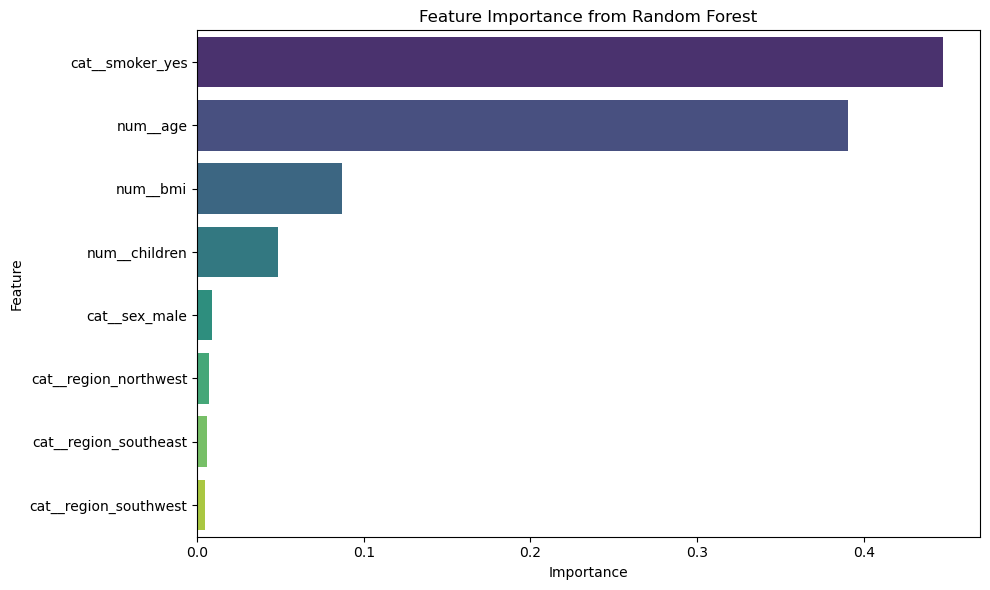

In [63]:
# Extract trained model from pipeline

rf_model = best_model.named_steps['regressor']
feature_names = preprocessor.get_feature_names_out()
importances = rf_model.feature_importances_

# Create DataFrame for plotting
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()


#  Predicting Medical Insurance Charges for a New input Query

In [65]:
# Create a DataFrame for the new query
new_data = pd.DataFrame({
    'age': [35],
    'sex': ['female'],
    'bmi': [28.5],
    'children': [2],
    'smoker': ['yes'],
    'region': ['southeast']
})
predicted_log = best_model.predict(new_data)
predicted_cost = np.expm1(predicted_log)[0]

#The model returns the log-transformed value, which we convert back to the original scale using np.expm1().
#This helps evaluate the real-world applicability of the trained model.

print(f" Predicted Medical Insurance Charges: ₹{predicted_cost:,.2f}")


 Predicted Medical Insurance Charges: ₹21,361.44


# Conclusion

This notebook successfully built and evaluated multiple regression models to predict medical insurance charges based on patient information. 
Key features influencing costs were smoker **status**, **age**, and **BMI**. 
Visual analysis (pairplots, feature importance, actual vs predicted plots) confirmed the model's reliability.
With additional data or feature engineering, this model could serve as a strong foundation for real-world insurance cost prediction tools.

Among the models tested, **Random Forest** and **Gradient Boosting** delivered the best performance among all baseline models, with Random Forest further improved through hyperparameter tuning.
- After hyperparameter tuning, **Random Forest** showed improved generalization performance with : Good R² Score & Lower RMSE, making it a reliable choice for this prediction task.


### Evaluation Summary:
- Model performance was evaluated using multiple metrics:**R², Adjusted R², MAE, MSE, and RMSE**.
- **Train R² Score:**    0.9236
- **Test R² Score:**     0.8984
- **Adjusted R²:**       0.8952 
- **MAE:**               2060.76 
- **MSE:**               18676606.77 
- **RMSE:**              4321.64
- 
The feature importance plot of Random Forest revealed that **smoker** had the highest impact, followed by **age** and **BMI**.
  
Overall, the model provides a strong predictive base for estimating medical insurance costs, especially in scenarios where patient data is known.